BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

In [1]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling==4.*

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
drive  sample_data


In [15]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [16]:
%ls

kaggle.json            test_features.csv   train_labels.csv
sample_submission.csv  train_features.csv


# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle competition website (the URL is given on Canvas). Go to the **Rules** page. Accept the rules of the competition and download the dataset. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [17]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [18]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

In [20]:
df

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,...,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,...,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,...,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525.0,1000.0,327.0,36.367112,-8.774761,NaN,Rufiji,Morogoro,5,4.0,255.0,...,monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
11980.0,1000.0,1743.0,34.531524,-9.769604,NaN,Lake Nyasa,Iringa,11,5.0,35.0,...,annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional
35778.0,NaN,-13.0,38.974416,-5.420823,NaN,Pangani,Tanga,4,5.0,1000.0,...,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other,non functional


# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [19]:
X = df.drop(columns='status_group')
y = df['status_group']

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1948)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [22]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5411548073129028


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [26]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=1948, max_depth=8)
)
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
hand pump                      3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
other                 2
hand pump             3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=1948))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [27]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.7493620939102986
Validation Accuracy Score: 0.7390572390572391


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [25]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6
tuning = []
for d in range(1, 20):
  model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(random_state=1948, max_depth=d)
  )
  model.fit(X_train, y_train)
  training_acc = accuracy_score(y_train, model.predict(X_train))
  val_acc = accuracy_score(y_val, model.predict(X_val))
  tuning.append((d, round(training_acc, 2), round(val_acc,2)))
print(tuning)

[(1, 0.63, 0.64), (2, 0.66, 0.66), (3, 0.7, 0.7), (4, 0.71, 0.71), (5, 0.72, 0.71), (6, 0.73, 0.72), (7, 0.74, 0.73), (8, 0.75, 0.74), (9, 0.76, 0.74), (10, 0.78, 0.75), (11, 0.8, 0.75), (12, 0.81, 0.76), (13, 0.83, 0.76), (14, 0.85, 0.76), (15, 0.87, 0.76), (16, 0.89, 0.76), (17, 0.9, 0.76), (18, 0.92, 0.76), (19, 0.93, 0.76)]


# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

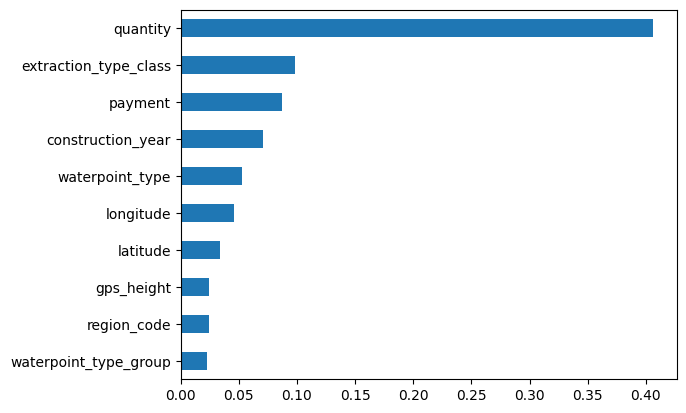

In [33]:
features = model_dt['ordinalencoder'].get_feature_names_out()
importances = model_dt['decisiontreeclassifier'].feature_importances_
pd.Series(data=importances, index=features).sort_values().tail(10).plot(kind='barh')
plt.xlabel = 'Relative Importance'

In [36]:
predictions = pd.DataFrame(data=model_dt.predict(X_test), index=X_test.index)
predictions.columns = ['status_group']

In [38]:
predictions.to_csv('module_1_submission.csv')

In [39]:
from google.colab import files
files.download('module_1_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#kaggle competitions submit -c bloomtech-water-pump-challenge -f module_1_submission.csv -m "module_1_submission"